In [3]:
import pandas as pd

# Replace with the actual file paths to your parquet files
df_30s = pd.read_parquet('df_30s.parquet')
df_60s = pd.read_parquet('df_60s.parquet')

# Sanity check
print("df_30s:", df_30s.shape)
df_30s.head()




df_30s: (1368000, 20)


,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,12.0,0,-0.000072,0.000300,-0.002023,0.005951,0.001607,0.370714,0.102052,7107.0,2.281320,0.000486,-0.000097,2021-01-05,11:00:00,1,1,Monday,1
1,8382.0,12.0,30,0.000015,0.000409,0.000440,0.008193,0.002206,0.382667,0.089951,17783.0,5.571606,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1
2,8382.0,12.0,60,-0.000020,0.000258,-0.000586,0.005349,0.001391,0.304000,0.098040,7844.0,5.975772,0.000334,-0.000207,2021-01-05,11:00:00,1,1,Monday,1
3,8382.0,12.0,90,0.000030,0.000182,0.000898,0.003616,0.000996,0.306500,0.159914,10877.0,6.003413,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1
4,8382.0,12.0,120,0.000036,0.000211,0.001094,0.004162,0.001156,0.367000,-0.026375,9224.0,2.293206,0.000315,-0.000006,2021-01-05,11:00:00,1,1,Monday,1


In [4]:
print("df_60s:", df_60s.shape)
df_60s.head()

df_60s: (684000, 20)


,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,12.0,0,-0.000027,0.000360,-0.001583,0.014144,0.002729,0.376897,0.095793,24890.0,3.983192,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1
1,8382.0,12.0,60,0.000005,0.000223,0.000312,0.008965,0.001711,0.305250,0.128977,18721.0,5.989592,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1
2,8382.0,12.0,120,0.000029,0.000187,0.001738,0.007604,0.001453,0.360833,0.008997,18513.0,3.119304,0.000103,0.000053,2021-01-05,11:00:00,1,1,Monday,1
3,8382.0,12.0,180,-0.000008,0.000215,-0.000467,0.007326,0.001650,0.301833,0.031202,35827.0,4.447586,0.000012,0.000025,2021-01-05,11:00:00,1,1,Monday,1
4,8382.0,12.0,240,0.000050,0.000189,0.002992,0.008347,0.001500,0.291500,-0.074440,41679.0,3.859149,0.000116,-0.000091,2021-01-05,11:00:00,1,1,Monday,1


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


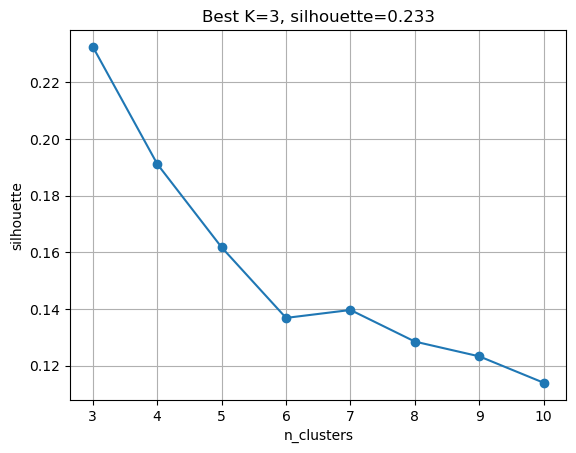

cluster
0    154
1    101
2    125
Name: count, dtype: int64
   stock_id  week  cluster
0    8382.0     1        1
1    8382.0     2        1
2    8382.0     3        1
3    8382.0     4        1
4    8382.0     5        1


In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import MiniRocketMultivariate
import matplotlib.pyplot as plt

# ── 0) Filter to Monday–Thursday via day_of_week (0–3) ──────────────────────────
train = df_60s[df_60s['day_of_week'].isin([1,2,3,4])]
test = df_60s[df_60s['day_of_week'] == 5]

# ── 1) Build 3D array of multivariate series (n_series × n_buckets × n_features) ─
features = [
    "log_ret_mean","realized_volatility",
    "spread", "imbalance", "rv_rolling"
]

# aggregate duplicates
df_agg = (
    train
    .groupby(['stock_id','week','bucket_start'])[features]
    .mean()
    .reset_index()
)

# unique (stock,week) index
series_index = df_agg[['stock_id','week']].drop_duplicates().set_index(['stock_id','week'])
n_series = len(series_index)
buckets = sorted(df_agg['bucket_start'].unique())
n_buckets = len(buckets)
n_features = len(features)

# fill array
X = np.zeros((n_series, n_buckets, n_features))
for idx, (stock, wk) in enumerate(series_index.index):
    sub = df_agg[(df_agg.stock_id==stock)&(df_agg.week==wk)].set_index('bucket_start').reindex(buckets).fillna(0)
    X[idx] = sub[features].values

# ── 2) Standardize each feature channel globally ─────────────────────────────────
flat = X.reshape(-1, n_features)
scaler = StandardScaler().fit(flat)
X_scaled = scaler.transform(flat).reshape(n_series, n_buckets, n_features)

# ── 3) MiniRocketMultivariate embedding ────────────────────────────────────────
X_mr = X_scaled.transpose(0,2,1)        # → (n_series, n_features, n_buckets)
mr = MiniRocketMultivariate(random_state=0)
mr.fit(X_mr)
X_feat = mr.transform(X_mr)             # → (n_series, n_rocket_features)

# ── 4) Auto-select K by silhouette ──────────────────────────────────────────────
best_k, best_s = None, -1
scores = []
max_k = min(10, int(np.sqrt(n_series)))
for k in range(3, max_k+1):
    lbl = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(X_feat)
    s = silhouette_score(X_feat, lbl)
    scores.append((k,s))
    if s>best_s:
        best_k, best_s = k, s

# plot
ks, ss = zip(*scores)
plt.plot(ks, ss, 'o-')
plt.xlabel('n_clusters'); plt.ylabel('silhouette'); plt.grid(True)
plt.title(f'Best K={best_k}, silhouette={best_s:.3f}')
plt.show()

# ── 5) Final clustering & merge back ────────────────────────────────────────────
labels = KMeans(n_clusters=best_k, random_state=0, n_init=10).fit_predict(X_feat)
cluster_df = series_index.reset_index()
cluster_df['cluster'] = labels

# attach cluster to all df_60s rows by stock_id & week
train = train.merge(cluster_df, on=['stock_id','week'], how='left')

print(cluster_df['cluster'].value_counts().sort_index())
print(cluster_df.head())


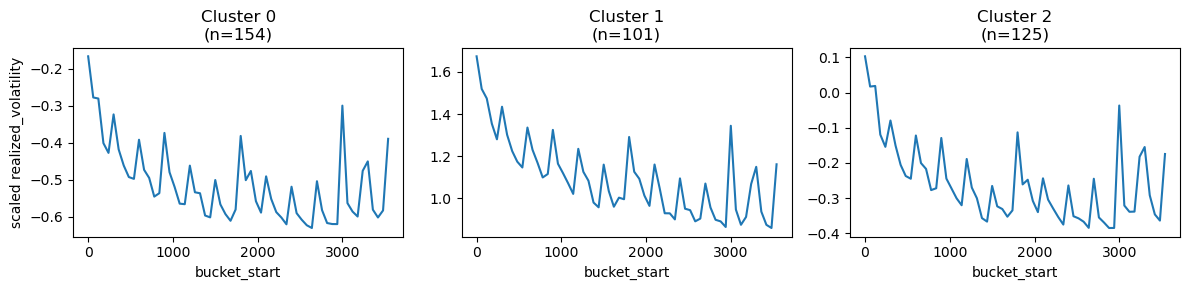

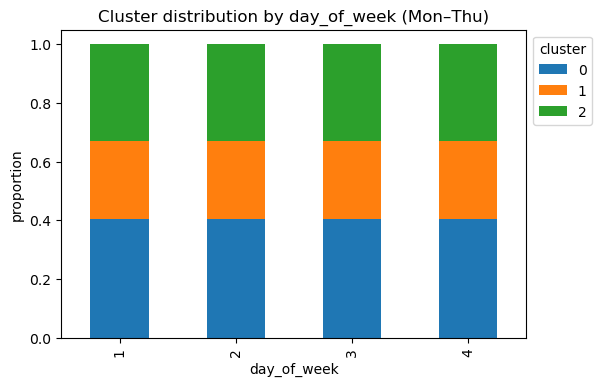

In [6]:

# Plot cluster centroids for realized_volatility
plt.figure(figsize=(4*best_k, 3))
for c in range(best_k):
    mask = labels == c
    # mean pattern of realized_volatility channel
    fidx = features.index("realized_volatility")
    avg_pattern = X_scaled[mask, :, fidx].mean(axis=0)
    plt.subplot(1, best_k, c+1)
    plt.plot(buckets, avg_pattern)
    plt.title(f'Cluster {c}\n(n={mask.sum()})')
    plt.xlabel('bucket_start')
    if c==0:
        plt.ylabel('scaled realized_volatility')
plt.tight_layout()
plt.show()

# Plot cluster distribution by day_of_week for train set
cluster_df2 = train[train['day_of_week'].isin([4,1,2,3])]
dist = pd.crosstab(cluster_df2['day_of_week'], cluster_df2['cluster'], normalize='index')
dist.plot(kind='bar', stacked=True, figsize=(6,4))
plt.title('Cluster distribution by day_of_week (Mon–Thu)')
plt.xlabel('day_of_week')
plt.ylabel('proportion')
plt.legend(title='cluster', bbox_to_anchor=(1,1))
plt.show()

In [7]:
test.to_parquet("test_60s.parquet", index=False)
train.to_parquet("train_60s_clustered.parquet", index=False)


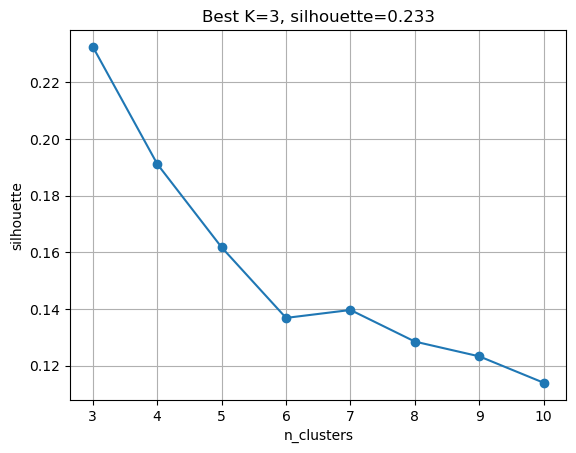

cluster
0    154
1    101
2    125
Name: count, dtype: int64
   stock_id  week  cluster
0    8382.0     1        1
1    8382.0     2        1
2    8382.0     3        1
3    8382.0     4        1
4    8382.0     5        1


In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import MiniRocketMultivariate
import matplotlib.pyplot as plt

# ── 0) Filter to Monday–Thursday via day_of_week (0–3) ──────────────────────────
train1 = df_30s[df_30s['day_of_week'].isin([1,2,3,4])]
test1 = df_30s[df_30s['day_of_week'] == 5]

# ── 1) Build 3D array of multivariate series (n_series × n_buckets × n_features) ─
features = [
    "log_ret_mean","realized_volatility",
    "spread", "imbalance", "rv_rolling"
]

# aggregate duplicates
df_agg = (
    train
    .groupby(['stock_id','week','bucket_start'])[features]
    .mean()
    .reset_index()
)

# unique (stock,week) index
series_index = df_agg[['stock_id','week']].drop_duplicates().set_index(['stock_id','week'])
n_series = len(series_index)
buckets = sorted(df_agg['bucket_start'].unique())
n_buckets = len(buckets)
n_features = len(features)

# fill array
X = np.zeros((n_series, n_buckets, n_features))
for idx, (stock, wk) in enumerate(series_index.index):
    sub = df_agg[(df_agg.stock_id==stock)&(df_agg.week==wk)].set_index('bucket_start').reindex(buckets).fillna(0)
    X[idx] = sub[features].values

# ── 2) Standardize each feature channel globally ─────────────────────────────────
flat = X.reshape(-1, n_features)
scaler = StandardScaler().fit(flat)
X_scaled = scaler.transform(flat).reshape(n_series, n_buckets, n_features)

# ── 3) MiniRocketMultivariate embedding ────────────────────────────────────────
X_mr = X_scaled.transpose(0,2,1)        # → (n_series, n_features, n_buckets)
mr = MiniRocketMultivariate(random_state=0)
mr.fit(X_mr)
X_feat = mr.transform(X_mr)             # → (n_series, n_rocket_features)

# ── 4) Auto-select K by silhouette ──────────────────────────────────────────────
best_k, best_s = None, -1
scores = []
max_k = min(10, int(np.sqrt(n_series)))
for k in range(3, max_k+1):
    lbl = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(X_feat)
    s = silhouette_score(X_feat, lbl)
    scores.append((k,s))
    if s>best_s:
        best_k, best_s = k, s

# plot
ks, ss = zip(*scores)
plt.plot(ks, ss, 'o-')
plt.xlabel('n_clusters'); plt.ylabel('silhouette'); plt.grid(True)
plt.title(f'Best K={best_k}, silhouette={best_s:.3f}')
plt.show()

# ── 5) Final clustering & merge back ────────────────────────────────────────────
labels = KMeans(n_clusters=best_k, random_state=0, n_init=10).fit_predict(X_feat)
cluster_df = series_index.reset_index()
cluster_df['cluster'] = labels

# attach cluster to all df_30s rows by stock_id & week
train1 = train1.merge(cluster_df, on=['stock_id','week'], how='left')

print(cluster_df['cluster'].value_counts().sort_index())
print(cluster_df.head())


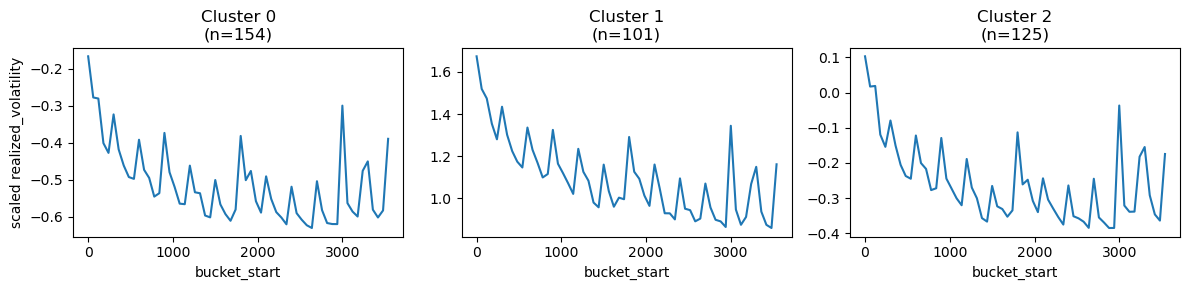

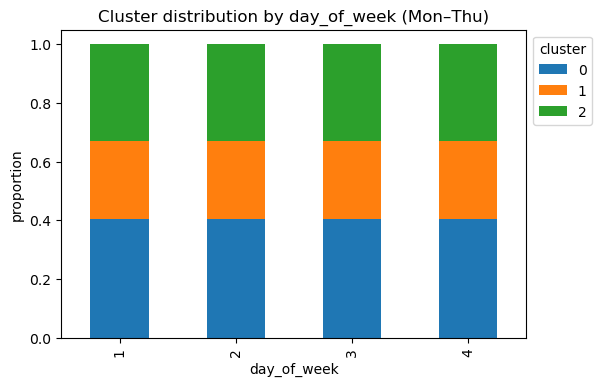

In [9]:
# Plot cluster centroids for realized_volatility
plt.figure(figsize=(4*best_k, 3))
for c in range(best_k):
    mask = labels == c
    # mean pattern of realized_volatility channel
    fidx = features.index("realized_volatility")
    avg_pattern = X_scaled[mask, :, fidx].mean(axis=0)
    plt.subplot(1, best_k, c+1)
    plt.plot(buckets, avg_pattern)
    plt.title(f'Cluster {c}\n(n={mask.sum()})')
    plt.xlabel('bucket_start')
    if c==0:
        plt.ylabel('scaled realized_volatility')
plt.tight_layout()
plt.show()

# Plot cluster distribution by day_of_week for train set
cluster_df2 = train1[train1['day_of_week'].isin([4,1,2,3])]
dist = pd.crosstab(cluster_df2['day_of_week'], cluster_df2['cluster'], normalize='index')
dist.plot(kind='bar', stacked=True, figsize=(6,4))
plt.title('Cluster distribution by day_of_week (Mon–Thu)')
plt.xlabel('day_of_week')
plt.ylabel('proportion')
plt.legend(title='cluster', bbox_to_anchor=(1,1))
plt.show()

In [10]:
test1.to_parquet("test1_30s.parquet", index=False)
train1.to_parquet("train1_30s_clustered.parquet", index=False)


In [11]:
train1

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,...,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week,cluster
0,8382.0,12.0,0,-0.000072,0.000300,-0.002023,0.005951,0.001607,0.370714,0.102052,...,2.281320,0.000486,-0.000097,2021-01-05,11:00:00,1,1,Monday,1,1
1,8382.0,12.0,30,0.000015,0.000409,0.000440,0.008193,0.002206,0.382667,0.089951,...,5.571606,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1,1
2,8382.0,12.0,60,-0.000020,0.000258,-0.000586,0.005349,0.001391,0.304000,0.098040,...,5.975772,0.000334,-0.000207,2021-01-05,11:00:00,1,1,Monday,1,1
3,8382.0,12.0,90,0.000030,0.000182,0.000898,0.003616,0.000996,0.306500,0.159914,...,6.003413,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1,1
4,8382.0,12.0,120,0.000036,0.000211,0.001094,0.004162,0.001156,0.367000,-0.026375,...,2.293206,0.000315,-0.000006,2021-01-05,11:00:00,1,1,Monday,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094395,104919.0,1181.0,3450,0.000007,0.000084,0.000199,0.001958,0.000455,0.020333,-0.027715,...,1.160397,0.000045,0.000000,2021-10-04,16:00:00,189,4,Thursday,38,0
1094396,104919.0,1181.0,3480,0.000003,0.000073,0.000085,0.001532,0.000394,0.023000,0.067197,...,1.911605,0.000050,-0.000028,2021-10-04,16:00:00,189,4,Thursday,38,0
1094397,104919.0,1181.0,3510,0.000010,0.000058,0.000312,0.001078,0.000320,0.020667,0.003344,...,1.362367,0.000013,0.000006,2021-10-04,16:00:00,189,4,Thursday,38,0
1094398,104919.0,1181.0,3540,-0.000009,0.000055,-0.000255,0.001135,0.000300,0.021333,0.067800,...,2.340167,0.000016,0.000006,2021-10-04,16:00:00,189,4,Thursday,38,0


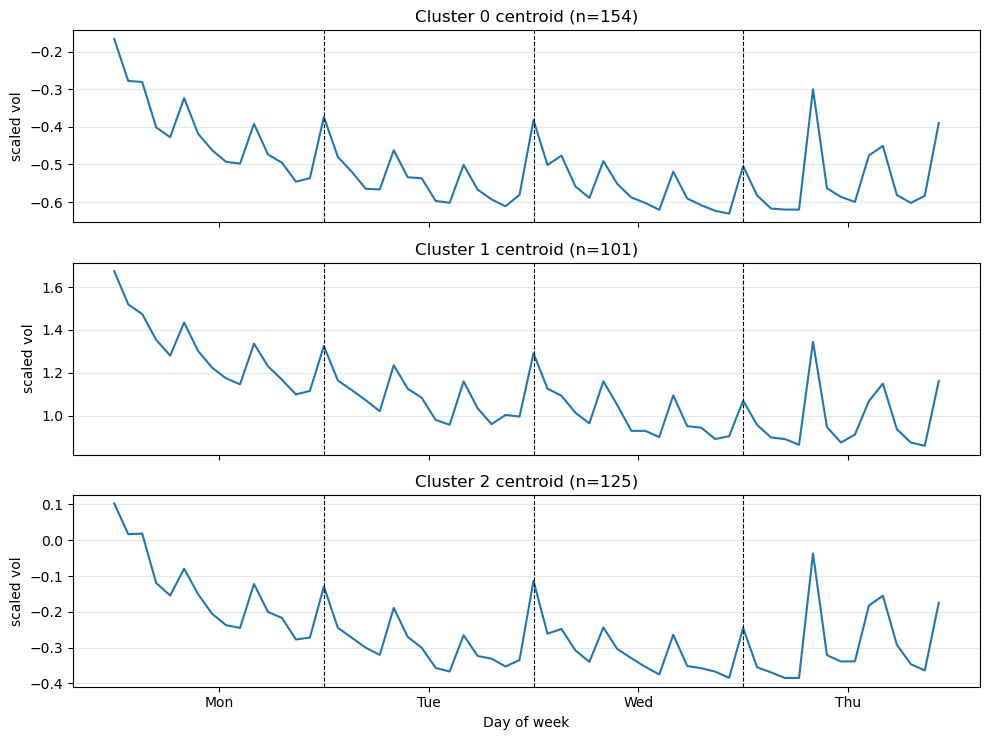

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you already have:
#   X_scaled       – array (n_series, n_buckets, n_features)
#   labels         – array (n_series,) of cluster assignments 0…K-1
#   features       – list of feature names (length n_features)
#   best_k         – number of clusters K
#   buckets        – sorted list of bucket_start values (length n_buckets)

# Find index of realized_volatility
fidx = features.index("realized_volatility")

# Number of buckets per day (we know we used Mon–Thu, 4 days)
n_series, n_buckets, n_feat = X_scaled.shape
bpd = n_buckets // 4

# Compute the 4-day centroid for each cluster, on the realized_volatility channel
centroids = np.zeros((best_k, 4*bpd))
for c in range(best_k):
    mask = labels == c
    # average across series in cluster, then flatten days
    arr = X_scaled[mask, :, fidx]               # shape (n_c, n_buckets)
    centroids[c] = arr.mean(axis=0)              # shape (n_buckets,)

# Plot
day_names = ["Mon","Tue","Wed","Thu"]
x = np.arange(4*bpd)

fig, axes = plt.subplots(best_k, 1, figsize=(10, 2.5*best_k), sharex=True)
if best_k == 1:
    axes = [axes]
for c,ax in enumerate(axes):
    ax.plot(x, centroids[c], lw=1.5)
    # vertical separators
    for d in range(1,4):
        ax.axvline(d*bpd, color="k", lw=0.8, linestyle="--")
    # weekday tick at middle of each segment
    mids = [(d+0.5)*bpd for d in range(4)]
    ax.set_xticks(mids)
    ax.set_xticklabels(day_names)
    ax.set_ylabel("scaled vol")
    ax.set_title(f"Cluster {c} centroid (n={(labels==c).sum()})")
    ax.grid(True, axis="y", alpha=0.3)

ax.set_xlabel("Day of week")
plt.tight_layout()
plt.show()


In [31]:

# List of features to aggregate by mean
feature_cols = ['log_ret_mean', 'log_ret_std', 'log_ret_sum', 'abs_volatility',
                'realized_volatility', 'spread', 'imbalance', 'depth',
                'depth_ratio', 'rv_rolling', 'mom_rolling']

# Group by cluster and bucket_start, then take the mean
cluster_bucket_means = (
    train1.groupby(['cluster', 'bucket_start'])[feature_cols]
    .mean()
    .reset_index()
)

# check results
cluster_bucket_means.to_parquet("centroidData.parquet", index=False)
cluster_bucket_means


,cluster,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling
0,0,0,-1.900823e-07,0.000066,-0.000005,0.001253,0.000348,0.030095,0.004148,82718.149892,1.531944,0.000054,5.557507e-07
1,0,30,2.431980e-07,0.000056,0.000007,0.001130,0.000308,0.029262,0.005965,89204.854978,1.521787,0.000048,1.631863e-06
2,0,60,1.581941e-07,0.000058,0.000005,0.001185,0.000319,0.028942,0.001384,88888.975649,1.493192,0.000048,-4.244189e-07
3,0,90,-2.773200e-07,0.000054,-0.000008,0.001074,0.000296,0.028758,0.003114,88803.157468,1.562988,0.000049,-1.778970e-07
4,0,120,3.892096e-07,0.000059,0.000012,0.001211,0.000325,0.028807,0.002985,89594.686688,1.549395,0.000049,-1.668999e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2,3450,2.362301e-07,0.000049,0.000007,0.000725,0.000270,0.732678,0.005986,6933.045333,6.187069,0.000037,1.273577e-07
356,2,3480,-3.908055e-07,0.000053,-0.000012,0.000801,0.000292,0.735399,0.012879,7178.692000,6.091904,0.000041,-1.178747e-06
357,2,3510,-1.100434e-07,0.000050,-0.000003,0.000728,0.000273,0.728928,0.014476,7366.135667,6.257402,0.000037,8.421835e-07
358,2,3540,2.622521e-07,0.000057,0.000008,0.000859,0.000310,0.743669,0.025563,7708.239000,6.416602,0.000044,-1.032601e-06


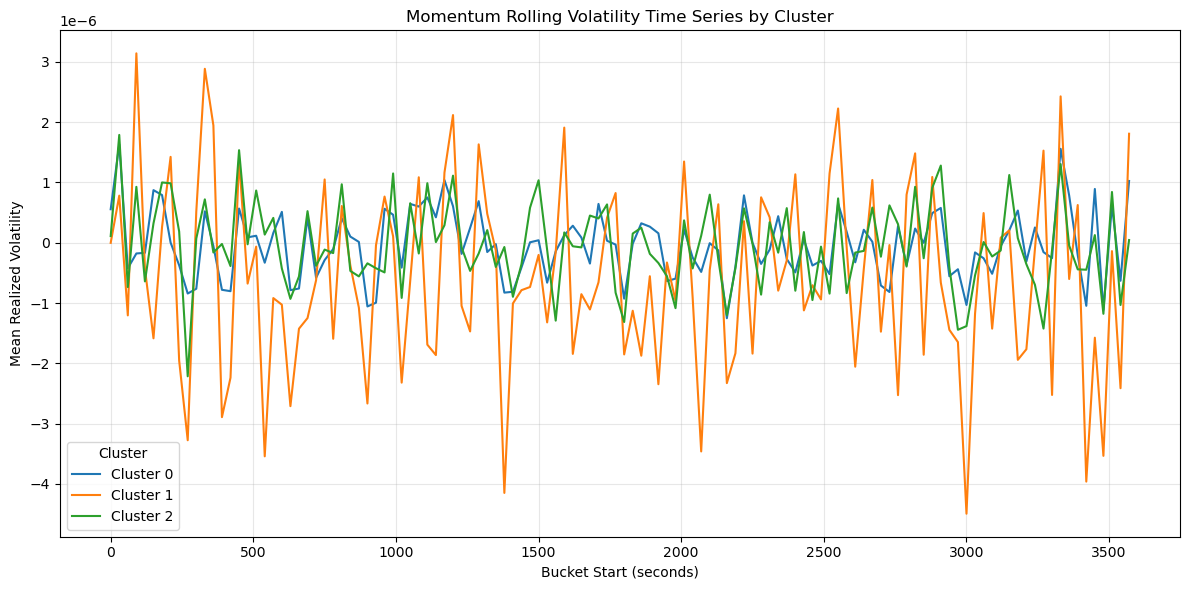

In [33]:
# Plot realized_volatility by time bucket for each cluster
plt.figure(figsize=(12, 6))

for cluster in sorted(cluster_bucket_means['cluster'].unique()):
    cluster_data = cluster_bucket_means[cluster_bucket_means['cluster'] == cluster]
    
    plt.plot(
        cluster_data['bucket_start'], 
        cluster_data['mom_rolling'], 
        label=f'Cluster {cluster}'
    )

plt.title('Momentum Rolling Volatility Time Series by Cluster')
plt.xlabel('Bucket Start (seconds)')
plt.ylabel('Mean Realized Volatility')
plt.grid(alpha=0.3)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()